{% include toc title="This Week" icon="file-text" %}

<div class="notice--info" markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Welcome to Week {{ page.week }}!

Welcome to week {{ page.week }} of Earth Analytics! This week, you will explore
the concept of uncertainty surrounding lidar raster data (and remote sensing
data in general). You will use the same data that you downloaded last week for class.

For your homework you'll also need to download the data below. You can do this most easily `using earthpy.get_data()`.

{% include/data_subsets/course_earth_analytics/_data-spatial-lidar.md %}

*******

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Homework 

### The Homework Assignment for This Week Can Be Found on Github 


<a href="https://github.com/earthlab-education/ea-python-2020-04-lidar-uncertainty-template" target="_blank">Click here to view the GitHub Repo with the assignment template. </a>

The lessons for this week have been moved to our <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/">Intermediate Earth Analytics Textbook. </a>

### Earth Analytics Textbook Chapters

Please read the following chapters to support completing this week's assignment:
* <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/">NEW: Raster / Vector Spatial Data Applications: Compare Lidar to Human Measured Tree Heights -- Uncertainty</a>
* <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/">REVIEW: Intro to Vector Spatial Data in Open Source Python</a>


### 1. Readings
* <a href="http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0054776" target="_blank">Influence of Vegetation Structure on Lidar-derived Canopy Height and Fractional Cover in Forested Riparian Buffers During Leaf-Off and Leaf-On Conditions</a>
* <a href="http://www.sciencedirect.com/science/article/pii/S0303243403000047" target="_blank">The characterization and measurement of land cover change through remote sensing: problems in operational applications?</a>
*  <a href="https://www.nde-ed.org/GeneralResources/ErrorAnalysis/UncertaintyTerms.htm" target="_blank">Learn more about the various uncertainty terms.</a>

</div>


## Example Homework Plots

The plots below are examples of what your plot could look like. Feel free to
customize or modify plot settings as you see fit! 

In [1]:
import os
from scipy import stats
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import rasterstats as rs
import earthpy as et

# Set plot styles
sns.set(font_scale=1.5)
sns.set_style("white")

In [2]:
# Get data from EarthPy
data = et.data.get_data('spatial-vector-lidar')

# Change home directory, and turn off warnings
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))
warnings.simplefilter('ignore')

In [3]:
# Import SJER plot locations & insitu data
sjer_data_path = os.path.join(
    'spatial-vector-lidar', 'california', 'neon-sjer-site')
# Read in insitu data and gather max and mean for each site location
sjer_insitu_path = os.path.join(
    sjer_data_path, '2013', 'insitu', 'veg_structure', 'D17_2013_SJER_vegStr.csv')
sjer_insitu = pd.read_csv(sjer_insitu_path)

# Read in lidar CHM data and centroids for SJER
sjer_points_path = os.path.join(
    sjer_data_path, 'vector_data', 'SJER_plot_centroids.shp')
sjer_points = gpd.read_file(sjer_points_path)

In [4]:
# Sjer Data -- Import lidar chm, run zonal stats on data

# Import lidar CHM
sjer_lidar_chm_path = os.path.join(
    sjer_data_path, '2013', 'lidar', 'SJER_lidarCHM.tif')

sjer_chm = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()
sjer_chm = sjer_chm.where(sjer_chm != 0, np.nan)

# Getting affine object
sjer_chm_aff = sjer_chm.rio.transform()

# Add buffer around lidar SJER plots & export as shapefile to use in zonal stats
sjer_plot_poly = sjer_points.copy()
sjer_plot_poly['geometry'] = sjer_points.geometry.buffer(20)
sjer_plots_buffer_path = os.path.join(
    'spatial-vector-lidar', 'outputs', 'sjer_plot_buffer.shp')
sjer_plot_poly.to_file(sjer_plots_buffer_path)

# Extract raster stats
sjer_lidar = rs.zonal_stats(sjer_plots_buffer_path,
                            sjer_chm.values,
                            affine=sjer_chm_aff,
                            geojson_out=True,
                            nodata=0,
                            copy_properties=True,
                            stats="max mean")

# Create gdf and clean up col names
sjer_lidar_mean_max = gpd.GeoDataFrame.from_features(sjer_lidar)
sjer_lidar_mean_max = sjer_lidar_mean_max.rename(
    columns={'max': 'lidar_max', 'mean': 'lidar_mean'})
sjer_lidar_mean_max = sjer_lidar_mean_max[[
    "Plot_ID", "geometry", "lidar_max", "lidar_mean"]]

#### Plots 1 - 4: Scatterplots With Regression & a 1:1 Line

For both the SJER and SOAP field sites, create scatter plots that compare:

* **MAXIMUM** canopy height model height in meters, extracted within a 20 meter radius, compared to **MAXIMUM** tree
height derived from the *insitu* field site data.
* **MEAN** canopy height model height in meters, extracted within a 20 meter radius, compared to **MEAN** tree height derived from the *insitu* field site data.

For each of these plots be sure to:

1. Place lidar data values on the X axis and human measured tree height on the Y axis
2. Include a calculated **regression line** (HINT use `sns.plot()` to achieve this line) that describes the relationship of lidar of the data
3. Include a separate **1:1 line** that can be used to compare the regression fit to a perfect 1:1 fit. 
4. Set the x and y limits to be the SAME for each individual plot. This means that for plot 3 the x and y limits are the same. For plot 4 the x and y limits are the same. NOTE: You may have different limits for each plot depending on the data being rendered. Thus plot 3 x and plot 3 y axis may be the same. But plot 3 x axis does NOT need to be the same as plot 4 x axis. 
5. Plot the SJER plots within one figure using two ax elements (ax1, ax2) 
6. Plot the SOAP plots within one figure using two ax elements (ax1, ax2) 

HINT: the SOAP data have some inconsistencies in the column headings. One way to fix this is to use the syntax:

`"text-to-append-to-column" + dataframe_name["column-name-here"]`


In [5]:
# SJER -- Calculate mean and max from insitu data (csv file)

# Summarize insitu data
sjer_insitu_grp = sjer_insitu.groupby(
    'plotid').stemheight.agg(['max', 'mean']).reset_index()
sjer_insitu_grp = sjer_insitu_grp.rename(
    columns={'max': 'insitu_max', 'mean': 'insitu_mean'})

# Merge the two layers using a spatial join
sjer_lidar_insitu = sjer_lidar_mean_max.merge(sjer_insitu_grp,
                                              left_on='Plot_ID',
                                              right_on='plotid')

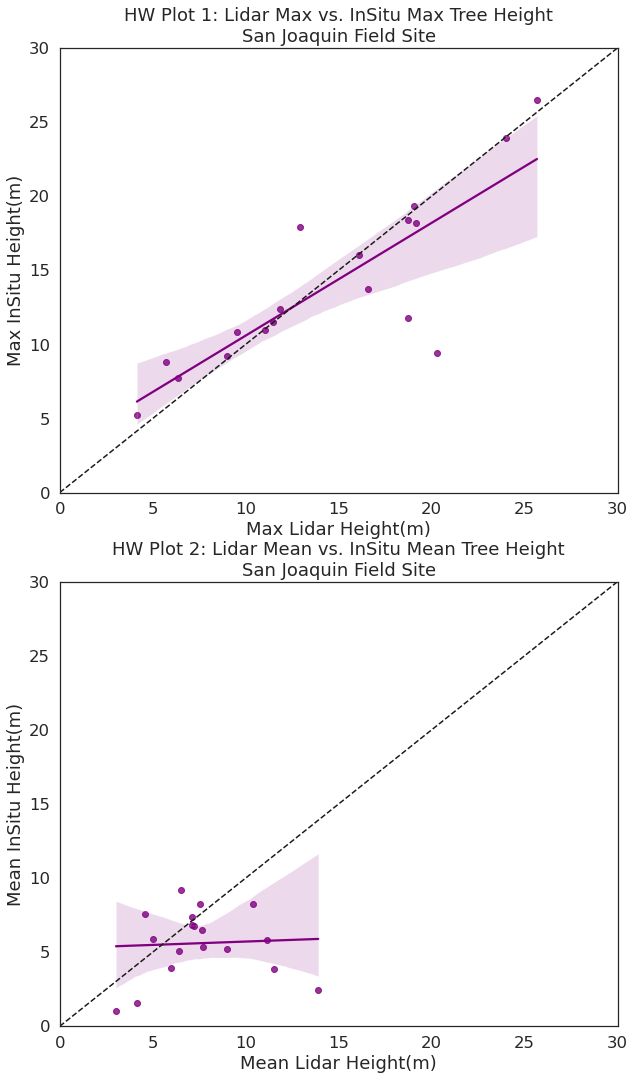

In [6]:
# Plot 1 & 2 - SJER  min and max
# Plot 1: Scatterplot of MAXIMUM canopy height model height in meters, extracted within a
# 20 meter radius, compared to MAXIMUM tree height derived from the insitu field site data at the SJER site.
# plot data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 18))

sns.regplot('lidar_max', 'insitu_max',
            data=sjer_lidar_insitu,
            color='purple',
            ax=ax1)

# 1:1 line
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k')
ax1.set(xlabel='Max Lidar Height(m)',
        ylabel='Max InSitu Height(m)',
        title='HW Plot 1: Lidar Max vs. InSitu Max Tree Height\nSan Joaquin Field Site',
        xlim=(0, 30),
        ylim=(0, 30))
sns.regplot('lidar_mean', 'insitu_mean',
            data=sjer_lidar_insitu,
            color='purple',
            ax=ax2)
ax2.set(xlabel='Mean Lidar Height(m)',
        ylabel='Mean InSitu Height(m)',
        title='HW Plot 2: Lidar Mean vs. InSitu Mean Tree Height\nSan Joaquin Field Site',
        xlim=(0, 30),
        ylim=(0, 30))
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--', c='k')
plt.show()

In [7]:
# Import SOAP plot locations & insitu data
soap_data_path = os.path.join(
    'spatial-vector-lidar', 'california', 'neon-soap-site')

path = os.path.join(soap_data_path, 'vector_data', 'SOAP_centroids.shp')
soap_centroids = gpd.read_file(path)

# Read in insitu data and gather max and mean for each site location
path = os.path.join(soap_data_path, '2013', 'insitu',
                    'veg-structure', 'D17_2013_SOAP_vegStr.csv')
soap_insitu = pd.read_csv(path)

In [8]:
# SOAP Data -- Import lidar chm, run zonal stats on data
soap_lidar_chm_path = os.path.join(
    soap_data_path, '2013', 'lidar', 'SOAP_lidarCHM.tif')

soap_chm = rxr.open_rasterio(soap_lidar_chm_path, masked=True).squeeze()
soap_chm = soap_chm.where(soap_chm != 0, np.nan)
soap_aff = soap_chm.rio.transform()

# Drop unnecessary columns
soap_centroids = soap_centroids[["ID", "geometry"]]

# Add buffer around lidar SOAP plots & export as shapefile to use in zonal stats
soap_centroids['geometry'] = soap_centroids.geometry.buffer(20)
soap_centroids_buffer_path = os.path.join(
    'spatial-vector-lidar', 'outputs', 'soap_centroids_buffer.shp')

soap_centroids.to_file(soap_centroids_buffer_path)

# extract zonal stats and turn to a pandas geo data frame
soap_lidar = rs.zonal_stats(soap_centroids_buffer_path,
                            soap_chm.values,
                            affine=soap_aff,
                            geojson_out=True,
                            copy_properties=True,
                            stats="max mean")

soap_lidar_mean_max = gpd.GeoDataFrame.from_features(soap_lidar)
soap_lidar_mean_max = soap_lidar_mean_max.rename(
    columns={'max': 'lidar_max', 'mean': 'lidar_mean', 'ID': 'plotid'})
soap_lidar_mean_max["plotid"] = "SOAP" + soap_lidar_mean_max["plotid"]

ParseException: Unknown type: 'SPATIAL-VECTOR-LIDAR/OUTPUTS/SOAP_CENTROIDS_BUFFER.SHP'


ValueError: Can't parse spatial-vector-lidar/outputs/soap_centroids_buffer.shp as a geojson Feature object

In [ ]:
# SOAP -- Calculate mean and max from insitu data (csv file), rename columns,
soap_insitu_mean_max = soap_insitu[["siteid", "plotid", "stemheight"]]
soap_insitu_mean_max = soap_insitu_mean_max.groupby(
    'plotid', as_index=False).stemheight.agg(['max', 'mean']).reset_index()
soap_insitu_mean_max = soap_insitu_mean_max.rename(
    columns={'max': 'insitu_max', 'mean': 'insitu_mean'})
#soap_insitu_mean_max['insitu_id'] = [pid[4:] for pid in soap_insitu['plotid']]
# Spatial join the soaproot lidar mean max data to the insitu
# account for the difference in col names
soap_lidar_insitu = soap_lidar_mean_max.merge(soap_insitu_mean_max,
                                              left_on='plotid',
                                              right_on='plotid')
# soap_joined['geometry'] = soap_joined.centroid

In [ ]:
# Plot Code only for HW Plots 3 & 4 Here
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 18))
#plt.subplots_adjust(top=1, bottom=.9)
sns.regplot('lidar_max', 'insitu_max',
            data=soap_lidar_insitu,
            color='purple',
            ax=ax1)

# 1:1 line
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k')

ax1.set(xlabel='Max Lidar Height(m)',
        ylabel='Max InSitu Height(m)',
        title='HW Plot 3: Lidar Max vs. InSitu Max Tree Height\nSoaproot Saddle Field Site',
        xlim=(0, 140),
        ylim=(0, 140))

sns.regplot('lidar_mean', 'insitu_mean',
            data=soap_lidar_insitu,
            color='purple',
            ax=ax2)

ax2.set(xlabel='Mean Lidar Height(m)',
        ylabel='Mean InSitu Height(m)',
        title='HW Plot 4: Lidar Mean vs. InSitu Mean Tree Height\nSoaproot Saddle Field Site',
        xlim=(0, 40),
        ylim=(0, 40))
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--', c='k')

plt.show()

### Calculated Regression Fit 

The above plots show the regression fit as calculated by the `seaborn` python package. Use `stats.linregression()` to calculate the slope and intercept of the regresion fit for each of the plots above. 

Print the outputs below. 


In [ ]:
## SJER - Regression

# slope, intercept, r_value, p_value, std_err = stats.linregress(
#     sjer_lidar_insitu.lidar_mean, sjer_lidar_insitu.insitu_mean)
# print("SJER - Mean Height Comparison")
# print("slope:", "print-slope-value-here",
#       "intercept:", "print-intercept-value-here")
# slope, intercept, r_value, p_value, std_err = stats.linregress(
#     sjer_lidar_insitu.lidar_max, sjer_lidar_insitu.insitu_max)
# print("\nSJER - Max Height Comparison")
# print("slope:", "print-slope-value-here",
#       "intercept:", "print-intercept-value-here")

In [ ]:
# Soaproot Saddle - Regression

slope, intercept, r_value, p_value, std_err = stats.linregress(
    soap_lidar_insitu.lidar_mean, soap_lidar_insitu.insitu_mean)
#print("\nSOAP - Mean Height Comparison")
#print("slope:", round(slope,2), "intercept:",round(intercept,2))

slope, intercept, r_value, p_value, std_err = stats.linregress(
    soap_lidar_insitu.lidar_max, soap_lidar_insitu.insitu_max)

#print("\nSOAP - Max Height Comparison")
#print("slope:", round(slope,2), "intercept:",round(intercept,2))


#### 1. Of all four relationships that you plotted above, which was the strongest?


## Is Mean or Max Height A Closer Comparison?

#### 2. List 2 reasons why lidar max height values may be larger than (over estimate) human measurements.


#### 3. List 2 reasons why lidar mean height values may be smaller than (underestimate) human measurements.



#### 4. List 2 systematic sources of error could impact differences between lidar and measured tree height values. 

Your answer here

#### 5. List 2 random sources of error that could impact differences between lidar and measured tree height values. 

Your answer here

In [ ]:
# PLOT 1: Overlay the field site point locations on top of the CHM for the SJER field site


# sjer_insitu[["geometry", "plotid", ]]
# # join data
# sjer_joined = sjer_insitu.merge(sjer_insitu_grp,
#                                left_on='plotid',
#                                right_on='plotid')

# just get the plot numbers to avoid case issues with the id's
# do we have to do this??
#sjer_insitu['insitu_id'] = [pid[4:] for pid in sjer_insitu['plotid']]

#### Plots 5 & 6

Overlay the field site point locations on top of the canopy height model for
both the NEON SJER and the SOAP field sites.

* Be sure to adjust the marker plot size based upon the average tree height using the insitu (human measured) data for each plot.
* IMPORTANT: Your basemap should ONLY show plots that have an average tree height value for them. 

In [ ]:
# #sjer_lidar['lidar_id'] = [pid[4:] for pid in sjer_lidar['Plot_ID']]
# #sjer_joined['geometry'] = sjer_joined.centroid

# # create plot and show chm
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(sjer_chm,
#           cmap='Greys',
#           extent=sjer_plt)

# # overlay field site locations
# sjer_joined.centroid.plot(ax=ax,
#                           marker='o',
#                           markersize=sjer_joined['insitu_mean']*80, c='purple')

# # add title
# ax.set_title(
#     "Homework Plot 1: SJER Study Site Locations \n Sized by Measured Max Tree Height")
# ax.set_axis_off()
# plt.show()

In [ ]:
# # Plot 6 - Soaproot Saddle
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(soap_chm, cmap='Greys', extent=[
#           soap_bounds[i] for i in [0, 2, 1, 3]])

# # overlay field site locations
# soap_joined.plot(ax=ax, marker='o',
#                  markersize=soap_joined['insitu_mean']*60, c='purple')

# # set boundaries and title
# ax.set_title(
#     "Homework Plot 2: SOAP Study Site Locations \n Overlayed on a Lidar Canopy Height Model")
# ax.set_axis_off()v

<!--

## Report Structure, Code Syntax & Knitr Output: 10%

| Full Credit | No Credit  |
|:----|----|
| `.ipynb` file submitted | |
| Code is written using "clean" code practices following the PEP-8 Python style guide |  |
| All cells contain code that runs  |  |
| All required `Python` packages are listed at the top of the document in a code chunk.  | |
| Lines of code are broken up at commas to reduce the line width and make the code more readable  | |
|==
| Code chunk arguments are used to hide warnings and code and just show output |  |


## Report Questions: 40%

| Full Credit | No Credit  |
|:----|----|
| Student compared the scatter plots of average and max height and determined which relationship is "better" (more comparable 1:1 ) for both field sites |  |
| Student discusses 2-3 potential sources of uncertainty that may have impacted these relationships |  |
| Student discusses differences in the relationships observed between the two field sites (SJER vs SOAP) |  |
| 1-2 readings from the homework are referenced in the report. (You can chose whether you'd like to use bookdown or create manual references)|  |
| 3 sources of uncertainty associated with 1) the lidar derived tree heights and 2) *insitu* tree height measurements are correctly identified as discussed in class and the readings | |
| Student identifies uncertainty sources listed above as systematic vs random | |


## Plots are Worth 50% of the Assignment Grade

### Plots 1 - 2 - Basemap - plot locations overlayed on top of the CHM for each field site.

| Full Credit | No Credit  |
|:----|----|
| Plots have a title that describes plot contents. |  |
| Plots have a 2-3 sentence caption that clearly describes plot contents. |  |

### Plots 3 - 6 - Scatterplots Insitu vs Lidar for San Joachin (SJER) & Soaproot (SOAP) Saddle sites

| Full Credit | No Credit  |
|:----|----|
| Scatter plot of maximum measured vs lidar tree height is included |  |
| Scatter plot of average measured vs lidar tree height is included |  |
| Plots have a title that describes plot contents. |  |
| X & Y axes are labeled appropriately. |  |
| Plots have a 2-3 sentence caption that clearly describes plot contents. |  |



**90% of the regression plot grade**

| Full Credit | No Credit  |
|:----|----|
| 1-2 Paragraphs are included that describe what these plots show in terms of the relationship between lidar and measured tree height and which metrics may or may not be better (average vs maximum height) |  |
-->

<!--
### 2. Complete the Assignment Below (5 points)

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Homework Submission

### Produce a Report

Create a new `Jupyter notebook`. Name it: **lastName-firstInitial-week5.ipynb**
Within your `notebook` document, write the code needed to create the plots listed below. 
Be sure to name your files as instructed! Submit a ipynb file and a .html file with your output to Canvas.


<!--

#### Answer Questions Below in Your Report -- turning this into multiple choice questions...

2. **Write *at least* 2 paragraphs:** In this class you learned the relationship between lidar derived canopy height models and measured tree height. Use that plots that you create below, the readings and the course lessons to answer the following questions
  * Which lidar tree height metric, (max vs. mean height) more closely relates to human measured tree height?
  * What sources of uncertainty (as discussed in class and the readings) may impact relationship between lidar vs human measured tree height?
  * Do you notice any differences in the relationship between the lidar vs human measured tree height between SJER vs SOAP field sites? Explain.
3. **Write *at least* 1 paragraph:** List a minimum of 3 sources of uncertainty associated with the lidar derived tree heights and 3 sources of uncertainty associated with *in situ* measurements of tree height. For each source of uncertainty, specify whether it is a random or systematic error. Be sure to reference the plots and readings as necessary.


#### Include the Plots Below
Be sure to describe what each plot shows in your final report.
Your plots do not need to be in the order below. I just listed them this way
to make it easier to keep track of and grade!

-->



#### Questions To Answer

Answer the following questions:

1. When comparing lidar vs measured tree height, which metric, mean or max height has a strong relationship? Why do you think one height measurement might be closer to measured then the other?
2. For SJER, provide the plot numbers, of the two plots that have the largest difference between lidar vs measured maximum tree height.
3. For SOAP, provide the plot numbers, of the two plots that have the largest difference between lidar vs measured maximum tree height.


### IMPORTANT: For All Plots
* Label x and y axes appropriately - include units
* Add a title to your plot that describes what the plot shows
* Add a brief, 1-3 sentence caption below each plot that describes what it shows.
